In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%tensorflow_version 2.x 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [ ]:
data_dir = '/content/drive/MyDrive/Springboard/Springboard/Capstone3/Dataset'
List_folder = os.listdir(data_dir)
print(List_folder)
data_dir = pathlib.Path(data_dir)

['Mild_Demented', 'Non_Demented', 'Very_Mild_Demented', 'Moderate_Demented']


In [ ]:
#number of images in the file 
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

6388


In [60]:
Mild_Demented = list(data_dir.glob('Mild_Demented/*'))
image = PIL.Image.open(str(Mild_Demented[0])) 
width, height = image. size
print(width, height)

128 128


In [ ]:
#load these images off disk
batch_size = 32
img_height = 160
img_width = 160
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6388 files belonging to 4 classes.
Using 5111 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  color_mode='grayscale',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6388 files belonging to 4 classes.
Using 1277 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


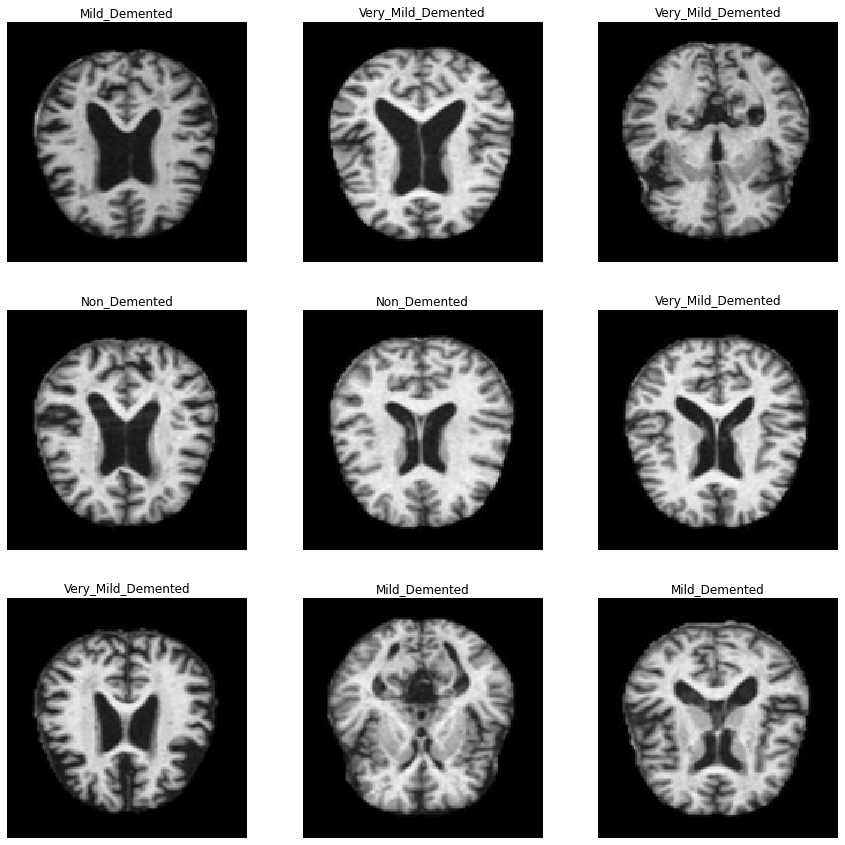

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    stacked_img = np.stack((images[i].numpy().astype("uint8"),)*3, axis=-1)
    plt.imshow(stacked_img[:,:,0], cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.title(class_names[labels[i]])
    plt.axis("off")



In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 1)
(32,)


In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Standardize the data
#The grayscale values are in the [0, 255] range. This is not ideal for a neural network; 
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# The pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9741177


In [ ]:
x= [1,2,4,5]
it = iter(x)

In [ ]:

print(next(it))
print(next(it))

In [ ]:
print(next(iter(x)))
print(next(iter(x)))

In [ ]:
#Create the model


model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(class_names))
])

In [ ]:
#Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

In [ ]:
#Train the model
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
160/160 [==============================] - 251s 2s/step - loss: 1.0104 - accuracy: 0.5116 - val_loss: 0.9198 - val_accuracy: 0.5497
Epoch 2/10
160/160 [==============================] - 112s 700ms/step - loss: 0.8284 - accuracy: 0.6048 - val_loss: 0.7217 - val_accuracy: 0.6695
Epoch 3/10
160/160 [==============================] - 110s 688ms/step - loss: 0.6017 - accuracy: 0.7320 - val_loss: 0.5077 - val_accuracy: 0.7807
Epoch 4/10
160/160 [==============================] - 110s 690ms/step - loss: 0.3415 - accuracy: 0.8599 - val_loss: 0.2677 - val_accuracy: 0.8943
Epoch 5/10
160/160 [==============================] - 112s 702ms/step - loss: 0.1679 - accuracy: 0.9401 - val_loss: 0.1943 - val_accuracy: 0.9178
Epoch 6/10
160/160 [==============================] - 111s 691ms/step - loss: 0.0627 - accuracy: 0.9789 - val_loss: 0.3106 - val_accuracy: 0.8810
Epoch 7/10
160/160 [==============================] - 111s 691ms/step - loss: 0.0535 - accuracy: 0.9855 - val_loss: 0.1857 - va

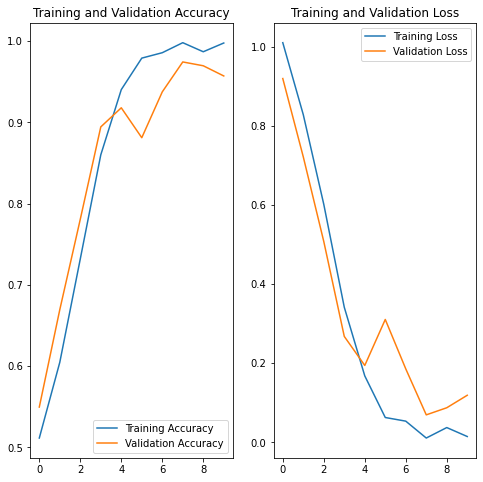

In [ ]:
#Visualize training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

def visualization(acc,val_acc,loss,val_loss):

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

visualization(acc,val_acc,loss,val_loss)

In [ ]:
unseendata_path = "/content/drive/MyDrive/Springboard/Springboard/Capstone3/non_seendata/moderate_44.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    unseendata_path, target_size=(img_height, img_width),color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to Moderate_Demented with a 99.98 percent confidence.


# ***Data augmentation***

In [ ]:
#Data augmentation
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.05),
    #layers.RandomZoom(0.1),
  ]
)


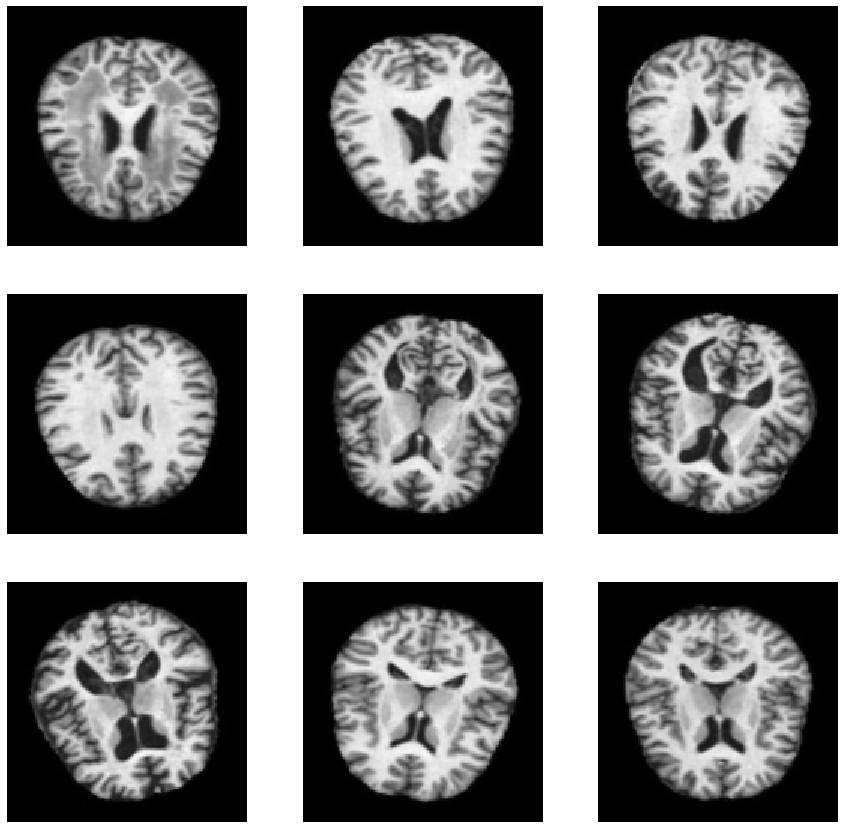

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    stacked_img_aug = np.stack((augmented_images[i].numpy().astype("uint8"),)*3, axis=-1)
    plt.imshow(stacked_img_aug[:,:,0], cmap='gray', vmin = 0, vmax = 255,interpolation='none')
    plt.axis("off")



In [ ]:
#Dropout
model_aug = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4)
])


In [ ]:
model_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model_aug.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 160, 160, 1)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 160, 160, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                  

In [ ]:
epochs = 10
history_aug = model_aug.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
160/160 [==============================] - 121s 752ms/step - loss: 1.0325 - accuracy: 0.5042 - val_loss: 0.9385 - val_accuracy: 0.5576
Epoch 2/10
160/160 [==============================] - 119s 742ms/step - loss: 0.9219 - accuracy: 0.5586 - val_loss: 0.8709 - val_accuracy: 0.5928
Epoch 3/10
160/160 [==============================] - 114s 712ms/step - loss: 0.8886 - accuracy: 0.5760 - val_loss: 0.8451 - val_accuracy: 0.5936
Epoch 4/10
160/160 [==============================] - 114s 712ms/step - loss: 0.8630 - accuracy: 0.5926 - val_loss: 0.9006 - val_accuracy: 0.5599
Epoch 5/10
160/160 [==============================] - 116s 723ms/step - loss: 0.8419 - accuracy: 0.6030 - val_loss: 0.7903 - val_accuracy: 0.6163
Epoch 6/10
160/160 [==============================] - 113s 709ms/step - loss: 0.8015 - accuracy: 0.6234 - val_loss: 0.7589 - val_accuracy: 0.6273
Epoch 7/10
160/160 [==============================] - 114s 710ms/step - loss: 0.7671 - accuracy: 0.6423 - val_loss: 0.7245 -

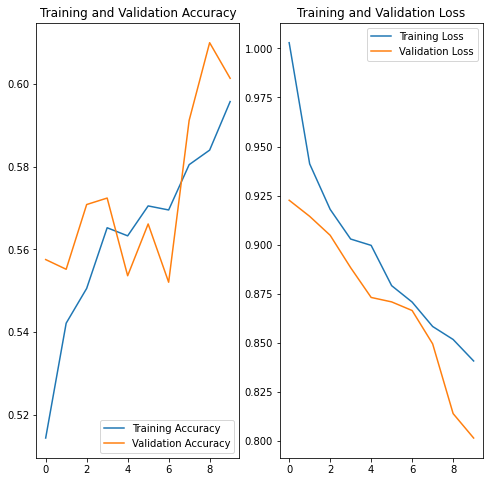

In [ ]:
#Visualize training results
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']

loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [30]:
unseendata_path = "/content/drive/MyDrive/Springboard/Springboard/Capstone3/non_seendata/mild_4.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    unseendata_path, target_size=(img_height, img_width),color_mode='grayscale'
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_aug.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Mild_Demented with a 41.36 percent confidence.


# **Hyperparameter Tuning Of Neural Networks using Keras Tuner**

https://www.tensorflow.org/tutorials/keras/keras_tuner

In [ ]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 5.2 MB/s 


In [ ]:

import keras_tuner as kt



In [ ]:
def model_builder(hp):
  '''
  Args:
    hp - Keras tuner object
  '''
  ###********
  model = keras.Sequential()
  model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,1)))
  model.add(layers.Conv2D(16, 1, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(32, 1, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Conv2D(64, 1, padding='same', activation='relu'))
  model.add(layers.MaxPooling2D())
  model.add(layers.Flatten())
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(layers.Dense(units=hp_units, activation='relu'))
  model.add(layers.Dense(len(class_names)))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(),
                metrics=['acc'])
  return model


In [ ]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_accuracy', # objective to optimize
max_epochs=10,
factor=3, # factor which you have seen above 
directory='/content/drive/MyDrive/Springboard/Springboard/Capstone3/non_seendata', # directory to save logs 
project_name='Alzhimer')



INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/Springboard/Springboard/Capstone3/non_seendata/Alzhimer/oracle.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:

tuner.search(train_ds, epochs=50,  callbacks=[stop_early])



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
224               |?                 |units
0.0001            |?                 |learning_rate
2                 |?                 |tuner/epochs
0                 |?                 |tuner/initial_epoch
2                 |?                 |tuner/bracket
0                 |?                 |tuner/round

Epoch 1/2
160/160 [==============================] - 525s 3s/step - loss: 1.1788 - acc: 0.4897
Epoch 2/2
160/160 [==============================] - 57s 352ms/step - loss: 1.1161 - acc: 0.5075


KeyError: ignored

In [ ]:
# Get the optimal hyperparameters
best_hp=tuner.get_best_hyperparameters()[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hps)
h_model.summary()

In [ ]:
history_hmodel = h_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=50
)

In [ ]:
val_acc_per_epoch = history_hmodel.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
train_label = np.concatenate([y for x, y in train_ds], axis=0)
train_img = np.concatenate([x for x, y in train_ds], axis=0)

# **Pretrained Model**

In [77]:
batch_size = 32
img_height = 120
img_width = 120
train_ds_color = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6388 files belonging to 4 classes.
Using 5111 files for training.


In [76]:
val_ds_color = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6388 files belonging to 4 classes.
Using 1277 files for validation.


In [81]:
for image_batch, labels_batch in val_ds_color:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 120, 120, 3)
(32,)


In [70]:
# load the InceptionResNetV2 architecture with imagenet weights as base
base_model = tf.keras.applications.InceptionResNetV2(
                     include_top=False,
                     weights='imagenet',
                     input_shape=(120,120,3)
                     )
  
base_model.trainable=False
# For freezing the layer we make use of layer.trainable = False
# means that its internal state will not change during training.
# model's trainable weights will not be updated during fit(),
# and also its state updates will not run.
  
model = tf.keras.Sequential([ 
        base_model,   
        tf.keras.layers.BatchNormalization(renorm=True),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

219070464/219055592 [==============================] - 2s 0us/step


In [82]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['acc'])
# categorical cross entropy is taken since its used as a loss function for 
# multi-class classification problems where there are two or more output labels.
# using Adam optimizer for better performance
# other optimizers such as sgd can also be used depending upon the model

In [83]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 2, 2, 1536)       54336736  
 onal)                                                           
                                                                 
 batch_normalization_203 (Ba  (None, 2, 2, 1536)       10752     
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 1536)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_18 (Dense)            (None, 512)               786944    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                      

In [84]:
early = tf.keras.callbacks.EarlyStopping( patience=10,
                                          min_delta=0.001,
                                          restore_best_weights=True)
# early stopping call back

In [85]:
# fit model
history = model.fit(train_ds_color,
                    steps_per_epoch=100,
                    validation_data=val_ds_color,
                    epochs=25,
                    callbacks=[early])



Epoch 1/10


ValueError: ignored

In [38]:
IMG_SHAPE = (img_height, img_width, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [32]:
from keras.models import Model
from keras.layers import Input 
input_tensor = Input(shape=(img_height,img_width,1) )
x = layers.Conv2D(3,(3,3),padding='same')(input_tensor)    # x has a dimension of (IMG_SIZE,IMG_SIZE,3)
out = base_model (x) 

base_model_new = Model(inputs=input_tensor,outputs=out)
base_model_new .summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 3)       30        
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,258,014
Trainable params: 2,223,902
Non-trainable params: 34,112
_________________________________________________________________


At this point this base_model will simply output a shape (32, 5, 5, 1280) tensor that is a feature extraction from our original (1, 160, 160, 3) image. The 32 means that we have 32 layers of differnt filters/features

In [41]:
for image, _ in train_ds.take(1):
   pass

#feature_batch = base_model(tf.image.grayscale_to_rgb(images))
feature_batch = base_model_new(images)
print(feature_batch.shape)

(32, 5, 5, 1280)


**Freezing the Base**

Disabling the training property of a layer.  No changes applied to the weights of any layers that are frozen during training.

In [ ]:
base_model_new.trainable = False
base_model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 160, 160, 3)       30        
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,258,014
Trainable params: 0
Non-trainable params: 2,258,014
_________________________________________________________________


Adding our Classifier

global average pooling layer will average the entire 5x5 area of each 2D feature map and return a single 1280 element vector per filter

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = keras.layers.Dense(4)

In [ ]:
model_mix = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  base_model_new,
  global_average_layer,
  prediction_layer
])

In [ ]:
model_mix.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 160, 160, 1)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 160, 160, 1)       0         
                                                                 
 model (Functional)          (None, 5, 5, 1280)        2258014   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_5 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,138
Trainable params: 5,124
Non-trainable params: 2,258,014
________________________________________

**Training the Model**

In [ ]:
base_learning_rate = 0.0001

model_mix.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
# We can evaluate the model right now to see how it does before training it on our new images
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model_mix.evaluate(val_ds, steps = validation_steps)

20/20 [==============================] - 13s 552ms/step - loss: 1.4350 - accuracy: 0.3578


In [ ]:
# Now we can train it on our images
history_mix = model_mix.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

acc = history_mix.history['accuracy']
print(acc)

Epoch 1/10
160/160 [==============================] - 122s 741ms/step - loss: 1.0857 - accuracy: 0.4715 - val_loss: 1.0211 - val_accuracy: 0.5145
Epoch 2/10
160/160 [==============================] - 117s 732ms/step - loss: 1.0099 - accuracy: 0.5101 - val_loss: 0.9809 - val_accuracy: 0.5294
Epoch 3/10
160/160 [==============================] - 118s 741ms/step - loss: 0.9792 - accuracy: 0.5246 - val_loss: 0.9594 - val_accuracy: 0.5372
Epoch 4/10
160/160 [==============================] - 116s 727ms/step - loss: 0.9636 - accuracy: 0.5345 - val_loss: 0.9486 - val_accuracy: 0.5395
Epoch 5/10
160/160 [==============================] - 121s 755ms/step - loss: 0.9540 - accuracy: 0.5392 - val_loss: 0.9361 - val_accuracy: 0.5427
Epoch 6/10
160/160 [==============================] - 116s 728ms/step - loss: 0.9417 - accuracy: 0.5484 - val_loss: 0.9279 - val_accuracy: 0.5427
Epoch 7/10
160/160 [==============================] - 115s 719ms/step - loss: 0.9378 - accuracy: 0.5435 - val_loss: 0.9221 -

In [ ]:
model_mix.save("/content/drive/MyDrive/Springboard/Springboard/Capstone3/Alzhimer.h5")  # we can save the model and reload it at anytime in the future
new_model = tf.keras.models.load_model('/content/drive/MyDrive/Springboard/Springboard/Capstone3/Alzhimer.h5')

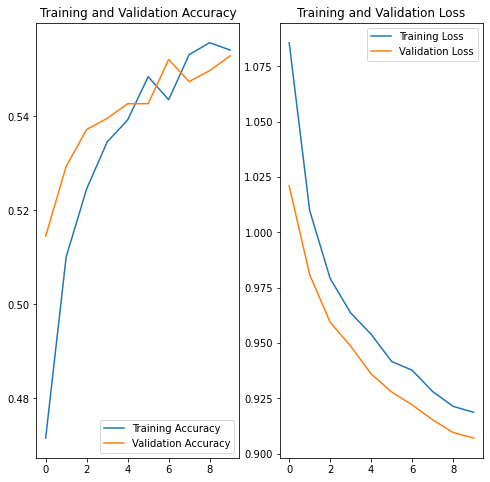

In [ ]:
#Visualize training results
acc = history_mix.history['accuracy']
val_acc = history_mix.history['val_accuracy']

loss = history_mix.history['loss']
val_loss = history_mix.history['val_loss']

epochs_range = range(initial_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
unseendata_path = "/content/drive/MyDrive/Springboard/Springboard/Capstone3/non_seendata/non_36.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    unseendata_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model_mix.predict(img)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

ValueError: ignored